<a href="https://colab.research.google.com/github/RonBartov/American_Sign_Language_Classification/blob/main/Copy_of_Deep_Learning_Final_Project_ASL_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
import matplotlib as plt
import pandas as pd
from PIL import Image,ImageOps
from google.colab import drive
import seaborn as sns
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [50]:
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random

from torchvision.utils import make_grid
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## **Import The Data**

Our data composed from 28x28 grayscale images (one channel images) that are the american sign language representation of one of the 24 american letters that not requires any motion, i.e all the american letters except J and Z.

The data is devided to:

Test and Validation data- 27,455 images
 
Test Data- 7,172 images 

The first column of the data frame represents the labels of the images. Because we have in total 26 american letters the labels are the numbers 0-25 correspondingly to the order of the letters, and because we are not using the letters J and Z we have the labels 0-8 and 10-24.

In [3]:
# Ron's paths
# csv_train_path = "/content/gdrive/MyDrive/Colab Notebooks/Deep Learning Final Project- ASL/sign_mnist_train.zip"
# csv_test_path = "/content/gdrive/MyDrive/Colab Notebooks/Deep Learning Final Project- ASL/sign_mnist_test.zip"

# Aviv's paths
csv_train_path = "/content/gdrive/MyDrive/DP_course/final/data/sign_mnist_train.csv"
csv_test_path = "/content/gdrive/MyDrive/DP_course/final/data/sign_mnist_test.csv"


In [178]:
df_train = pd.read_csv(csv_train_path)
df_test = pd.read_csv(csv_test_path)

In [179]:
lenn = len(df_train)
train_size = int(0.8 * len(df_train))
val_size = len(df_train) - train_size

df_val = df_train[train_size:]
df_train = df_train[:train_size-1]
print(len(df_train))

21963


## **Presenting an image from the data as an example**

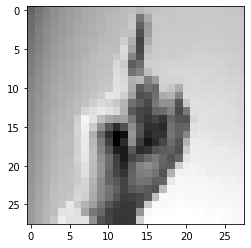

In [ ]:
pic_df = df_train.iloc[0:1,1:]
pic = pic_df.to_numpy()
plt.pyplot.imshow(pic.reshape(28,28), cmap="gray")

## **The Main Goal**

Our goal will be to be able to classify the letter from an image that we took with our personal phones.
This is one example for such an image 

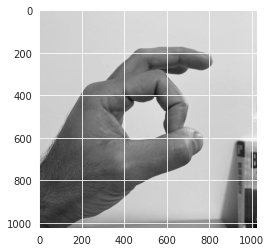

In [ ]:
ext_img_rgb = Image.open("/content/gdrive/MyDrive/Colab Notebooks/Deep Learning Final Project- ASL/ASL-test-img2.jpg")
ext_img_gray = ImageOps.grayscale(ext_img_rgb)
plt.pyplot.imshow(ext_img_gray, cmap='gray')

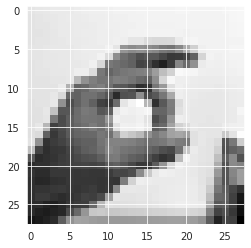

In [ ]:
# resize the image
ext_img_gray_res = ext_img_gray.resize((28, 28))
np_ext_img_gray = np.array(ext_img_gray_res)
np.shape(np_ext_img_gray)
plt.pyplot.imshow(ext_img_gray_res, cmap='gray')

## **Check if the data is balanced**

In order to know how to train our network weights properly, we would like to know if we have almost the same amount of images from each label, which can be treated as balanced training data. 

In [ ]:
# calculate the appearence percentage for each label
count_label = df_train.groupby('label').size() 
count_label_percentage = count_label/len(df_train.axes[0])
count_label_percentage

label
0     0.041013
1     0.036787
2     0.041668
3     0.043562
4     0.034857
5     0.043854
6     0.039701
7     0.036897
8     0.042324
10    0.040575
11    0.045201
12    0.038427
13    0.041923
14    0.043562
15    0.039628
16    0.046585
17    0.047132
18    0.043671
19    0.043198
20    0.042287
21    0.039410
22    0.044618
23    0.042397
24    0.040721
dtype: float64

In [ ]:
# calculate the distance to the average number of images per label (in terms of number of images)
label_avg_count = count_label.sum()//24
print("The average number of samples per label is: ", label_avg_count)
label_diffrence_from_avg = abs(count_label - label_avg_count)
label_diffrence_from_avg

The average number of samples per label is:  1143


label
0      17
1     133
2       1
3      53
4     186
5      61
6      53
7     130
8      19
10     29
11     98
12     88
13      8
14     53
15     55
16    136
17    151
18     56
19     43
20     18
21     61
22     82
23     21
24     25
dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


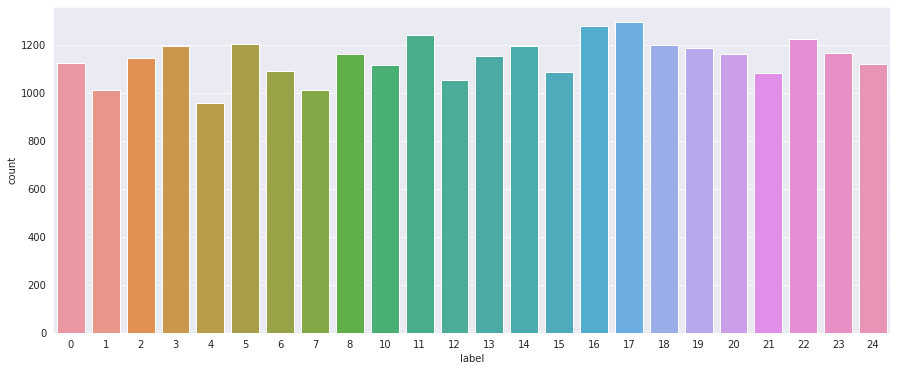

In [ ]:
# visualize the label distribution
y_train = df_train['label']
plt.pyplot.figure(figsize=(15,6))
sns.set_style("darkgrid")
sns.countplot(y_train)

## **Split the data into train and validation**

In [28]:
# y_train = df_train['label']
# y_test = df_test['label']
# del df_train['label']
# del df_test['label']
# x_train = df_train.values
# x_test = df_test.values
# x_train = x_train / 255
# x_test = x_test / 255
# x_train = x_train.reshape(-1,28,28,1)
# x_test = x_test.reshape(-1,28,28,1)
# x_test_tensor = torch.Tensor(x_test).swapaxes(1, 3).swapaxes(2 , 3)
# x_train_tensor = torch.Tensor(x_train).swapaxes(1, 3).swapaxes(2 , 3)

In [26]:
# print(x_test.shape)
# print(x_test_tensor.shape)

(7172, 28, 28, 1)
torch.Size([7172, 1, 28, 28])


In [ ]:
# norm_mean = 0.5 
# norm_std = 0.5 
# output_size = 24      # there are 10 classes
# train_loader = torch.utils.data.DataLoader(df_train, batch_size=500, shuffle=True , transform=transforms.Compose([
#                        transforms.ToTensor(),
#                        transforms.Normalize((norm_mean,), (norm_std,))
#                    ]))
# test_loader = torch.utils.data.DataLoader(df_test, batch_size=500, shuffle=True)
# print(train_loader.dataset.__len__())
# print(test_loader.dataset.__len__())

## **Creating the neural network for the classification**

Consider ResNet and VGG

In [151]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=75, kernel_size=(3, 3), stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(75)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=0)
        
        self.conv2 = nn.Conv2d(in_channels=75, out_channels=50, kernel_size=(3, 3), stride=1, padding=1)
        self.dropout = nn.Dropout(0.2)
        self.batchnorm2 = nn.BatchNorm2d(50)
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=0)
        
        self.conv3 = nn.Conv2d(in_channels=50, out_channels=25, kernel_size=(3, 3), stride=1, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(25)
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=1)
        
        self.fc1 = nn.Linear(25 * 4 * 4, 512)
        self.dropout2 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, 25)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.batchnorm1(x)
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = self.batchnorm2(x)
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.batchnorm3(x)
        x = self.pool3(x)

        x = x.view(-1, 25 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        
        return x

## **Creating the training function**

In [183]:
def test(model, test_loader, criterion):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = correct / total
        return accuracy

In [234]:
def data_loader(csv_data ,batch_size):
    # Convert the dataframe into a PyTorch tensor
    data = torch.tensor(csv_data.values, dtype=torch.float32)
    
    # Split the data into inputs (images) and targets (labels)
    inputs = data[:, 1:]
    targets = data[:, 0].long()
    
    # Normalize the inputs
    inputs = inputs / 255.0
    
    # Convert inputs into a 4D tensor for processing by the model
    inputs = inputs.view(-1, 1, 28, 28)
    
    # Create a TensorDataset from the inputs and targets
    dataset = TensorDataset(inputs, targets)
    
    # Create a DataLoader from the dataset
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [261]:
def train_model(train_data,val_data, model, criterion, optimizer, num_epochs = 500, batch_size= 500):
    model.train()

    # # Create a DataLoader from the dataset
    data_train = data_loader(train_data , batch_size)
    data_val = data_loader(val_data , batch_size)
    n = 0
    iters, losses = [], []
    iters_sub, train_accs, val_accs  = [], [] ,[]
    for epoch in range(num_epochs):

        for i, (images, labels) in enumerate(data_train):
            images, labels = images.to(device), labels.to(device)
            # Forward pass
            outputs = model(images)
            #loss = criterion(outputs.cpu(), labels.cpu())
            loss = F.nll_loss(outputs.cpu(), labels.cpu())
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            iters.append(n)
            losses.append(float(loss)/batch_size)  # compute *average* loss
            n+=1
            if n%50 ==0:
              iters_sub.append(n)
              train_cost = float(loss.detach().numpy())
              data_train_2 = data_loader(train_data[1:2000] , batch_size)
              train_acc = test(model, data_train_2 , criterion)

              train_accs.append(train_acc)
              val_acc = test(model, data_val , criterion)
              val_accs.append(val_acc)
              print(f'Epoch [{epoch+1}/{num_epochs}] '+"Iter %d. [Val Acc %.0f%%] [Train Acc %.0f%%, Loss %f]" % (
              n, val_acc * 100, train_acc * 100, train_cost))
              #print(f'Epoch [{epoch+1}/{num_epochs}] , Iteration[{n}], Loss: {loss.item()}')
            
    print('Finished Training')
    return iters, losses, iters_sub, train_accs, val_accs

##Train the model

In [251]:
model = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [102]:
from torchvision import models
from torchsummary import summary
summary(model.cuda(), (1,28,28))

input shape: torch.Size([2, 1, 28, 28])
second shape: torch.Size([2, 75, 14, 14])
3 shape: torch.Size([2, 50, 7, 7])
4 shape: torch.Size([2, 25, 4, 4])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 75, 28, 28]             750
       BatchNorm2d-2           [-1, 75, 28, 28]             150
         MaxPool2d-3           [-1, 75, 14, 14]               0
            Conv2d-4           [-1, 50, 14, 14]          33,800
           Dropout-5           [-1, 50, 14, 14]               0
       BatchNorm2d-6           [-1, 50, 14, 14]             100
         MaxPool2d-7             [-1, 50, 7, 7]               0
            Conv2d-8             [-1, 25, 7, 7]          11,275
       BatchNorm2d-9             [-1, 25, 7, 7]              50
        MaxPool2d-10             [-1, 25, 4, 4]               0
           Linear-11                  [-1, 512]         205,312
          Dropo

In [262]:
model.to(device)
iters, losses, iters_sub, train_accs, val_accs = train_model(df_train,df_val, model, criterion, optimizer, num_epochs = 3, batch_size= 128)


Epoch [1/3] Iter 50. [Val Acc 100%] [Train Acc 100%, Loss 0.009620]
Epoch [1/3] Iter 100. [Val Acc 98%] [Train Acc 98%, Loss 0.087262]
Epoch [1/3] Iter 150. [Val Acc 99%] [Train Acc 99%, Loss 0.007080]
Epoch [2/3] Iter 200. [Val Acc 100%] [Train Acc 100%, Loss 0.000788]
Epoch [2/3] Iter 250. [Val Acc 100%] [Train Acc 100%, Loss 0.000037]
Epoch [2/3] Iter 300. [Val Acc 100%] [Train Acc 100%, Loss 0.000088]
Epoch [3/3] Iter 350. [Val Acc 100%] [Train Acc 100%, Loss 0.000036]
Epoch [3/3] Iter 400. [Val Acc 100%] [Train Acc 100%, Loss 0.000041]
Epoch [3/3] Iter 450. [Val Acc 100%] [Train Acc 100%, Loss 0.000016]
Epoch [3/3] Iter 500. [Val Acc 100%] [Train Acc 100%, Loss 0.000073]
Finished Training


In [248]:
def plot_learning_curve(iters, losses, iters_sub, train_accs, val_accs):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve: Accuracy per Iteration")
    plt.plot(iters_sub, train_accs*100, label="Train")
    plt.plot(iters_sub, val_accs*100, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

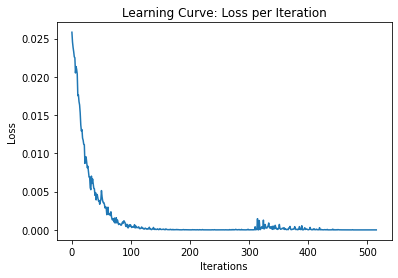

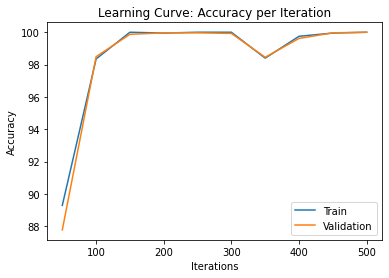

In [253]:
val_accs = np.array(val_accs)
train_accs = np.array(train_accs)
plot_learning_curve(iters, losses, iters_sub, train_accs, val_accs)

In [228]:
test_loader = data_loader(df_test , 120)

In [ ]:
##lets see some results

In [254]:
xxxxx = test(model, test_loader, criterion)
print(xxxxx)

0.9584495259341885


In [165]:
#torch.save(model, "/content/gdrive/MyDrive/DP_course/final/data/model1.pk.")